In [1]:
## 기본 라이브러리
import re
import warnings
import numpy as np
import pandas as pd

## 시각화 라이브러리
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
from chart_studio.plotly import plot, iplot
chart_studio.tools.set_credentials_file(username='dr.jeong9320', api_key='ggw0NGVO6S8rS9mrbNCr')

## 설정
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 500)

## Matplotlib 한글 폰트 설정
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/gulim.ttc' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
plt.rc('figure', titlesize=70)

%matplotlib inline

In [2]:
def OPS_plus(df):
    years = sorted(df.year.unique())
    for year in years:
        tmp = df.loc[df['year'] == year]
        obp_mean = tmp['OBP'].mean()
        slg_mean = tmp['SLG'].mean()
        df.loc[df['year'] == year, 'OPS+'] = (tmp['OBP'] / obp_mean) + (tmp['SLG'] / slg_mean) - 1        
    return df

In [3]:
ops = pd.read_csv('./data/Regular_Season_Batter_OPS.csv') # target 값이 OPS, missing value 처리 완료
slg = pd.read_csv('./data/Regular_Season_Batter_SLG.csv') # target 값이 SLG, missing value 처리 완료
obp = pd.read_csv('./data/Regular_Season_Batter_OBP.csv') # target 값이 OBP, missing value 처리 완료
rsb = pd.concat([ops, obp[['t_OBP']], slg[['t_SLG']]], axis=1) # target 값 결합

# 과거 팀명 변경
rsb.loc[rsb['team'].isin(['현대', '우리', '넥센', '키움']), 'team'] = '히어로즈'
rsb.loc[rsb['team'].isin(['OB']), 'team'] = '두산'
rsb.loc[rsb['team'].isin(['쌍방울']), 'team'] = 'SK'
rsb.loc[rsb['team'].isin(['해태']), 'team'] = 'KIA'
rsb = OPS_plus(rsb)

train = rsb.loc[rsb['t_OPS'] != -1] # trainset
test = rsb.loc[rsb['t_OPS'] == -1] # testset

df = train.copy().reset_index(drop=True)

In [4]:
col_lengths = len(df.columns)
df[df.columns[:round(col_lengths / 2)]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109 entries, 0 to 2108
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   batter_id    2109 non-null   int64  
 1   batter_name  2109 non-null   object 
 2   year         2109 non-null   float64
 3   age          2109 non-null   int64  
 4   position     2109 non-null   object 
 5   team         2109 non-null   object 
 6   career       2109 non-null   object 
 7   G            2109 non-null   int64  
 8   E            2109 non-null   int64  
 9   PA           2109 non-null   float64
 10  AB           2109 non-null   int64  
 11  R            2109 non-null   int64  
 12  H            2109 non-null   int64  
 13  2B           2109 non-null   int64  
 14  3B           2109 non-null   int64  
 15  HR           2109 non-null   int64  
 16  TB           2109 non-null   int64  
 17  RBI          2109 non-null   int64  
 18  SB           2109 non-null   int64  
 19  CS    

In [5]:
df[df.columns[round(col_lengths / 2):]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109 entries, 0 to 2108
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BB              2109 non-null   int64  
 1   HBP             2109 non-null   int64  
 2   IBB             2109 non-null   float64
 3   SO              2109 non-null   int64  
 4   GDP             2109 non-null   int64  
 5   SH              2109 non-null   float64
 6   SF              2109 non-null   float64
 7   avg             2109 non-null   float64
 8   OBP             2109 non-null   float64
 9   SLG             2109 non-null   float64
 10  OPS             2109 non-null   float64
 11  wOBA            2109 non-null   float64
 12  wRC             2109 non-null   float64
 13  WAR             2109 non-null   float64
 14  in_out_catcher  2109 non-null   object 
 15  t_OPS           2109 non-null   float64
 16  t_OBP           2109 non-null   float64
 17  t_SLG           2109 non-null   f

In [6]:
df[df.select_dtypes(['int', 'float']).columns[:11]].describe()

batter_id         year          age            G            E  \
count  2109.000000  2109.000000  2109.000000  2109.000000  2109.000000   
mean    179.073969  2010.739213    26.702703    74.123281     3.802750   
std      97.184708     4.801593     4.515133    44.434054     4.594359   
min       1.000000  1993.000000    18.000000     1.000000     0.000000   
25%     104.000000  2008.000000    23.000000    31.000000     0.000000   
50%     185.000000  2012.000000    26.000000    82.000000     2.000000   
75%     267.000000  2015.000000    30.000000   115.000000     5.000000   
max     344.000000  2017.000000    41.000000   144.000000    30.000000   

                PA           AB            R            H           2B  \
count  2109.000000  2109.000000  2109.000000  2109.000000  2109.000000   
mean    237.518255   206.578473    30.404457    57.246562    10.025605   
std     193.279382   167.407382    28.189401    51.561913     9.663273   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      50.000000    44.000000     5.000000     9.000000     1.000000   
50%     204.000000   176.000000    23.000000    44.000000     8.000000   
75%     415.000000   360.000000    50.000000   102.000000    17.000000   
max     672.000000   600.000000   135.000000   201.000000    46.000000   

                3B  
count  2109.000000  
mean      1.014699  
std       1.688018  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max      17.000000

In [7]:
df[df.select_dtypes(['int', 'float']).columns[11:22]].describe()

HR           TB          RBI           SB           CS  \
count  2109.000000  2109.000000  2109.000000  2109.000000  2109.000000   
mean      5.414414    85.544808    28.113798     5.645804     2.477477   
std       7.618881    80.837114    28.922545     9.489093     3.281986   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000    12.000000     3.000000     0.000000     0.000000   
50%       2.000000    63.000000    19.000000     2.000000     1.000000   
75%       8.000000   147.000000    45.000000     7.000000     4.000000   
max      53.000000   377.000000   146.000000    84.000000    21.000000   

                BB          HBP          IBB           SO          GDP  \
count  2109.000000  2109.000000  2109.000000  2109.000000  2109.000000   
mean     21.751541     3.514936     0.807492    39.007112     4.722617   
std      21.469185     4.137507     1.900494    30.702194     4.726521   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       3.000000     0.000000     0.000000    11.000000     1.000000   
50%      15.000000     2.000000     0.000000    35.000000     3.000000   
75%      36.000000     5.000000     1.000000    60.000000     8.000000   
max     108.000000    27.000000    30.000000   161.000000    24.000000   

                SH  
count  2109.000000  
mean      3.682788  
std       4.675260  
min       0.000000  
25%       0.000000  
50%       2.000000  
75%       6.000000  
max      41.000000

In [8]:
df[df.select_dtypes(['int', 'float']).columns[22:]].describe()

SF          avg          OBP          SLG          OPS  \
count  2109.000000  2109.000000  2109.000000  2109.000000  2109.000000   
mean      1.859175     0.237250     0.306639     0.343523     0.650161   
std       2.245719     0.100514     0.111043     0.164173     0.262321   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.203000     0.275000     0.271000     0.552000   
50%       1.000000     0.256000     0.329000     0.360000     0.688000   
75%       3.000000     0.290000     0.367000     0.432000     0.794000   
max      16.000000     1.000000     1.000000     3.000000     4.000000   

              wOBA          wRC          WAR        t_OPS        t_OBP  \
count  2109.000000  2109.000000  2109.000000  2109.000000  2109.000000   
mean      0.295721    71.621147     1.166939     0.666626     0.313907   
std       0.115183    71.914333     1.805161     0.227470     0.098412   
min       0.000000  -141.900000    -2.040000     0.000000     0.000000   
25%       0.258000    42.200000    -0.060000     0.579000     0.285000   
50%       0.315000    82.200000     0.360000     0.700000     0.333000   
75%       0.359000   111.100000     1.960000     0.800000     0.369000   
max       1.636000   978.500000    11.770000     2.000000     1.000000   

             t_SLG         OPS+  
count  2109.000000  2109.000000  
mean      0.352720     1.028727  
std       0.141711     0.806833  
min       0.000000    -1.000000  
25%       0.286000     0.727763  
50%       0.368000     1.149271  
75%       0.439000     1.469865  
max       1.333000    10.979853

In [9]:
z = df.select_dtypes(['int', 'float']).corr()
fig = go.Figure()
fig.add_trace(go.Heatmap(
    z=z,
    x=z.columns,
    y=z.columns,
    colorscale='Teal'
))
fig.update_layout(autosize=False, width=700, height=700, title='Correlation Heatmap')
fig.show()
# plot(fig, filename='kbo_corr', auto_open=True)

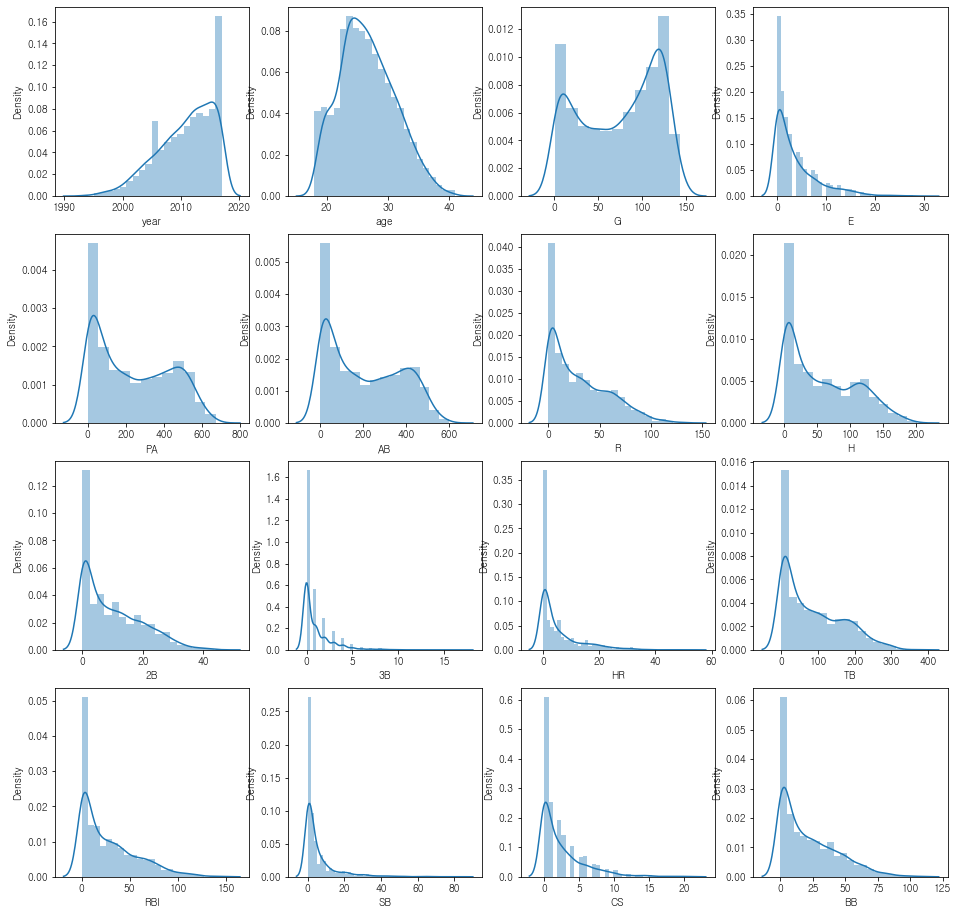

In [10]:
columns = ['year', 'age', 'G', 'E', 'PA', 'AB', 'R', 'H', '2B', '3B',
           'HR', 'TB', 'RBI', 'SB', 'CS', 'BB', 'HBP', 'IBB', 'SO', 'GDP', 'SH',
           'SF', 'avg', 'OBP', 'SLG', 'OPS', 'wOBA', 'wRC', 'WAR', 't_OPS',
           't_OBP', 't_SLG', 'OPS+']
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for i, col in enumerate(columns[:16], 1):
    plt.subplot(4, 4, i)
    sns.distplot(train[col])
#     plt.title(col)

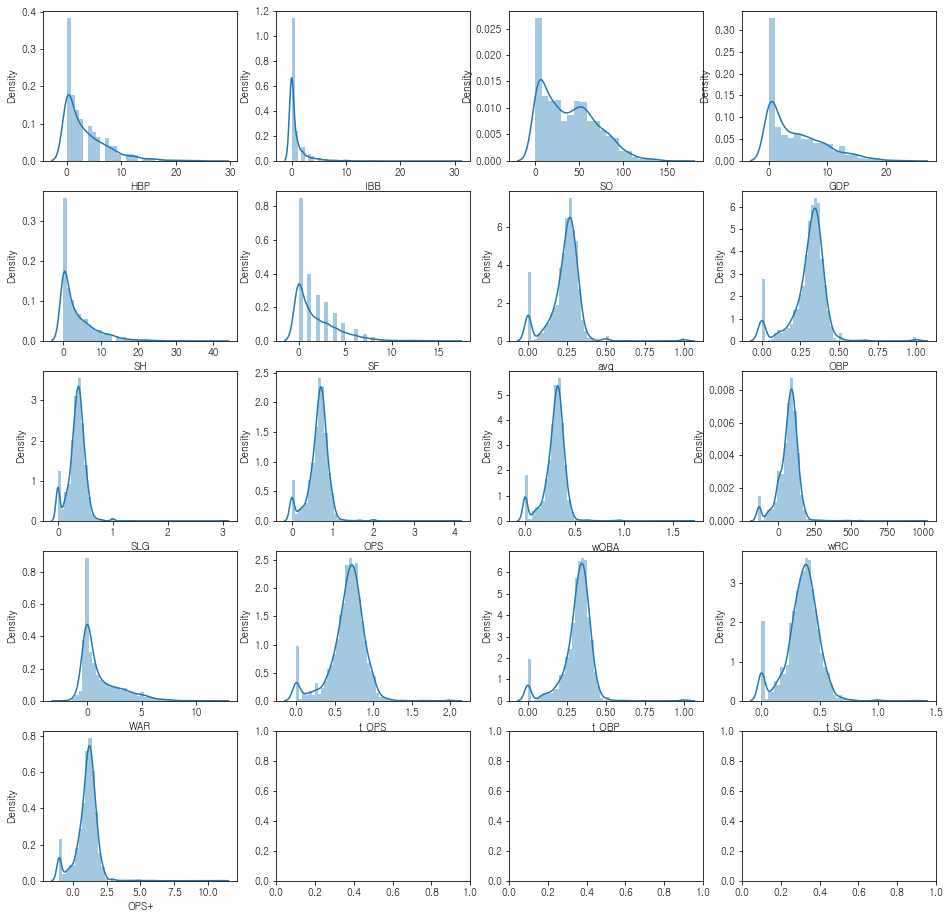

In [11]:
fig, ax = plt.subplots(5, 4, figsize=(16, 16))

for i, col in enumerate(columns[16:], 1):
    plt.subplot(5, 4, i)
    sns.distplot(train[col])

### Boxplot

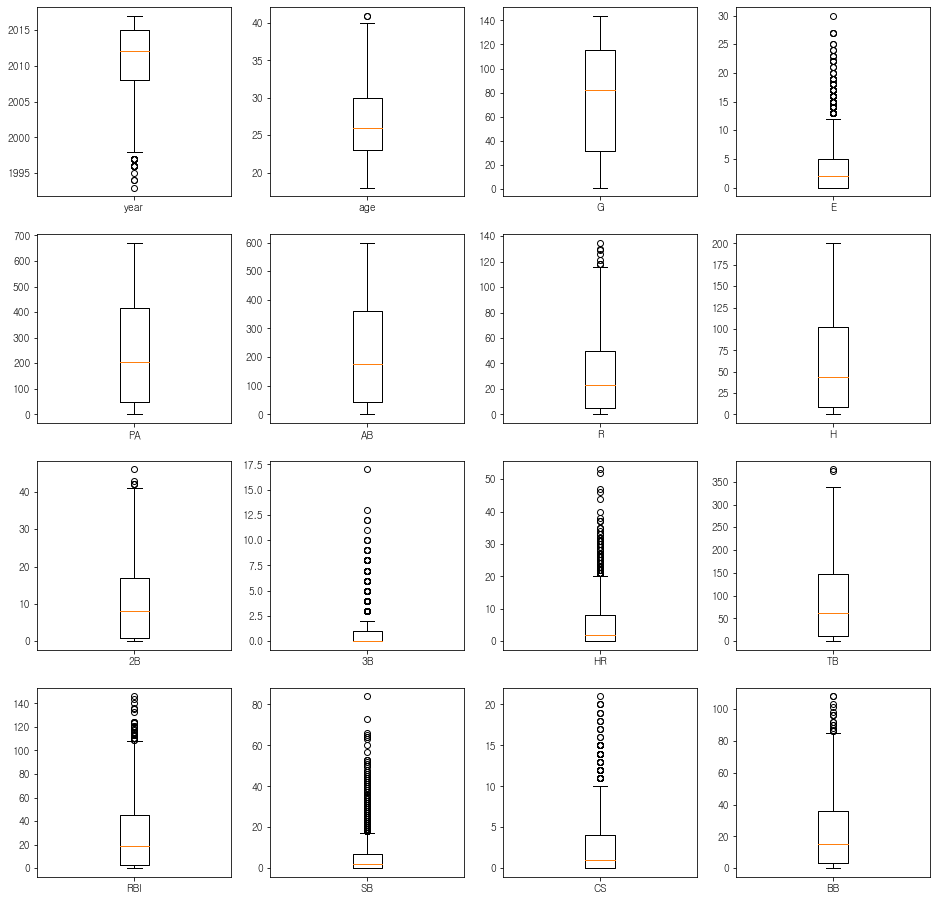

In [12]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for i, col in enumerate(columns[:16], 1):
    plt.subplot(4, 4, i)
    plt.boxplot(train[col])
    plt.xticks(ticks=[1], labels=[col])

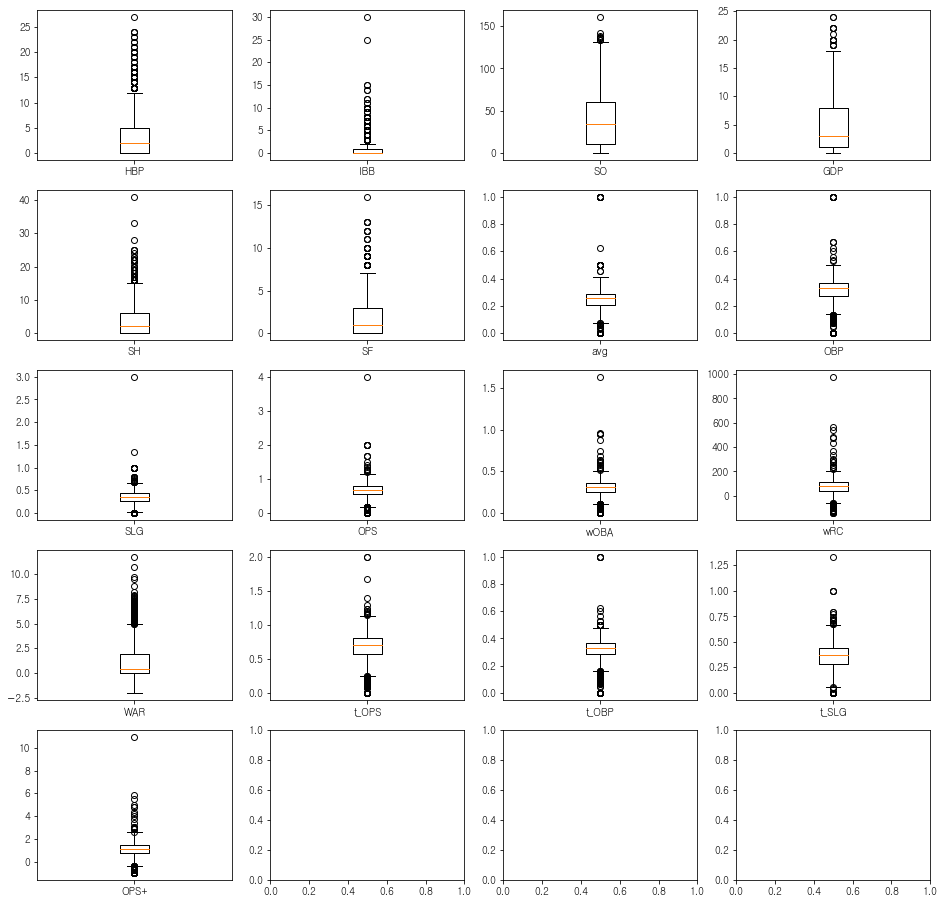

In [13]:
fig, ax = plt.subplots(5, 4, figsize=(16, 16))

for i, col in enumerate(columns[16:], 1):
    plt.subplot(5, 4, i)
    plt.boxplot(train[col])
    plt.xticks(ticks=[1], labels=[col])

### Pairplot

In [14]:
def regplots(df, target, figsize=(20, 40)):
    columns = df.select_dtypes(['int', 'float']).columns.tolist()
    columns.remove('batter_id')
    
    fig, axs = plt.subplots(round(len(columns) / 3), 3, figsize=figsize, constrained_layout=True)
    for i, col1 in enumerate(columns, 1):
        if target == col1:
            continue
        if i > columns.index(target):
            i -= 1
        plt.subplot(11, 3, i)
        sns.regplot(x=col1, y=target, data=df, scatter_kws={'s':5}, line_kws={'color':'r'})
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlabel(xlabel=col1, fontsize=18)
        plt.ylabel(ylabel=target, fontsize=12)
    fig.suptitle(t=target.upper(), fontsize=20, verticalalignment='baseline')
    return plt.show();

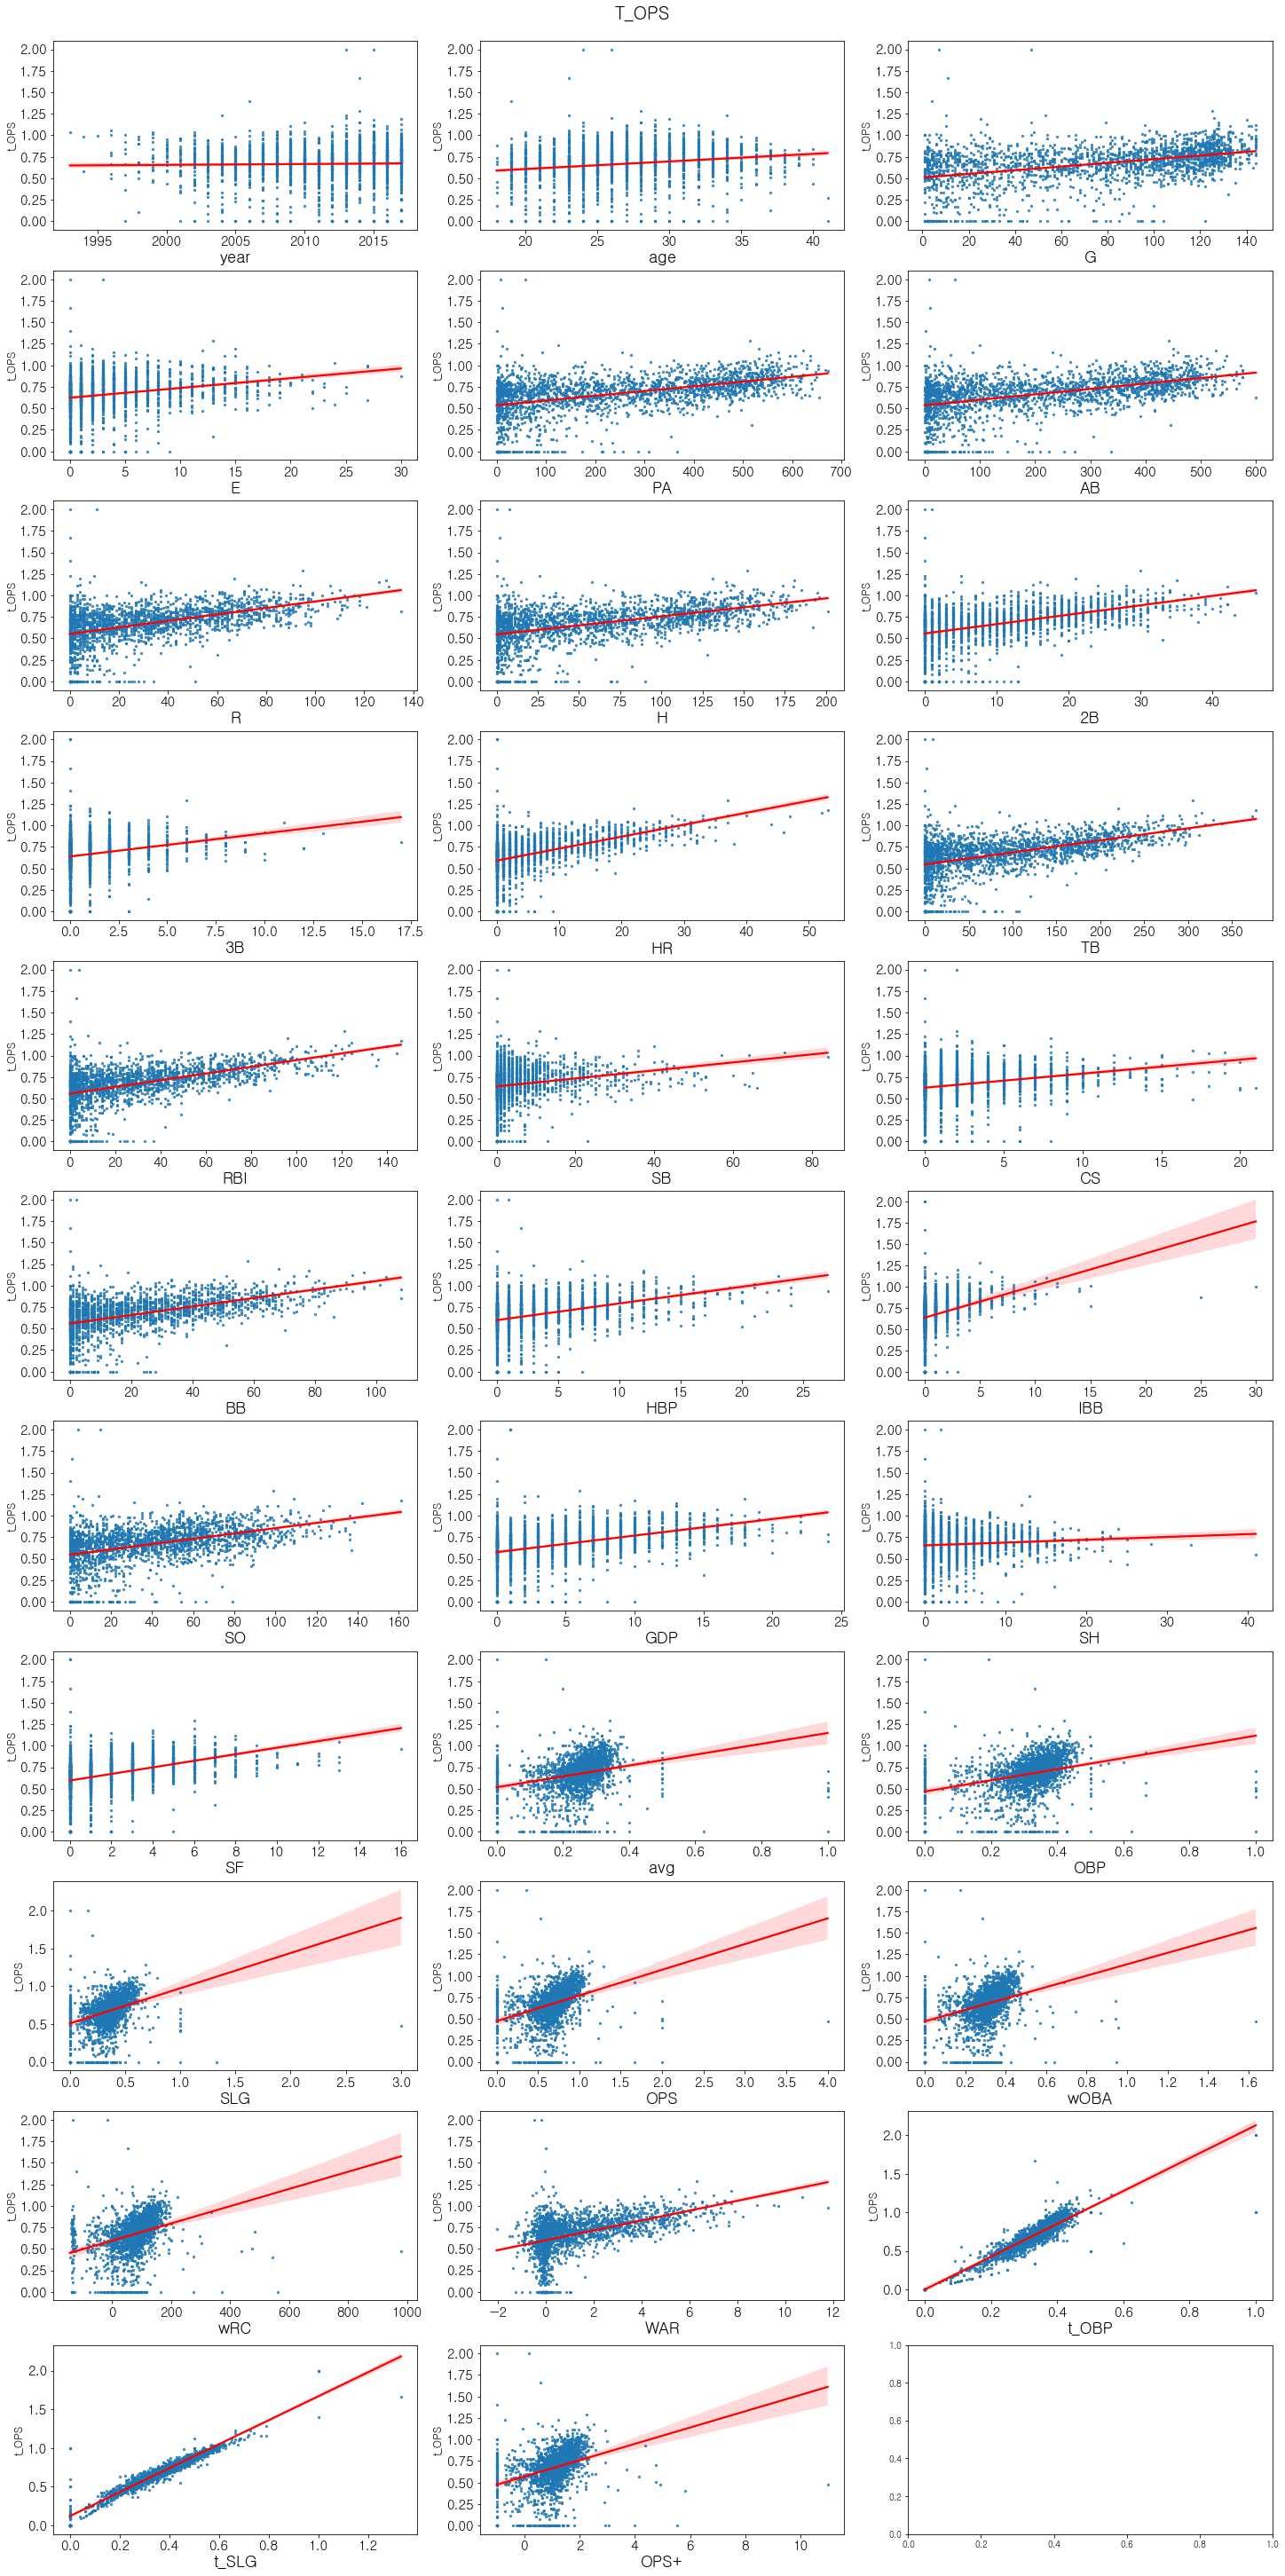

In [15]:
regplots(df.loc[df['t_OPS'] != -1], 't_OPS')

### 포지션별(야수, 포수, 지명타자) 기록 분포

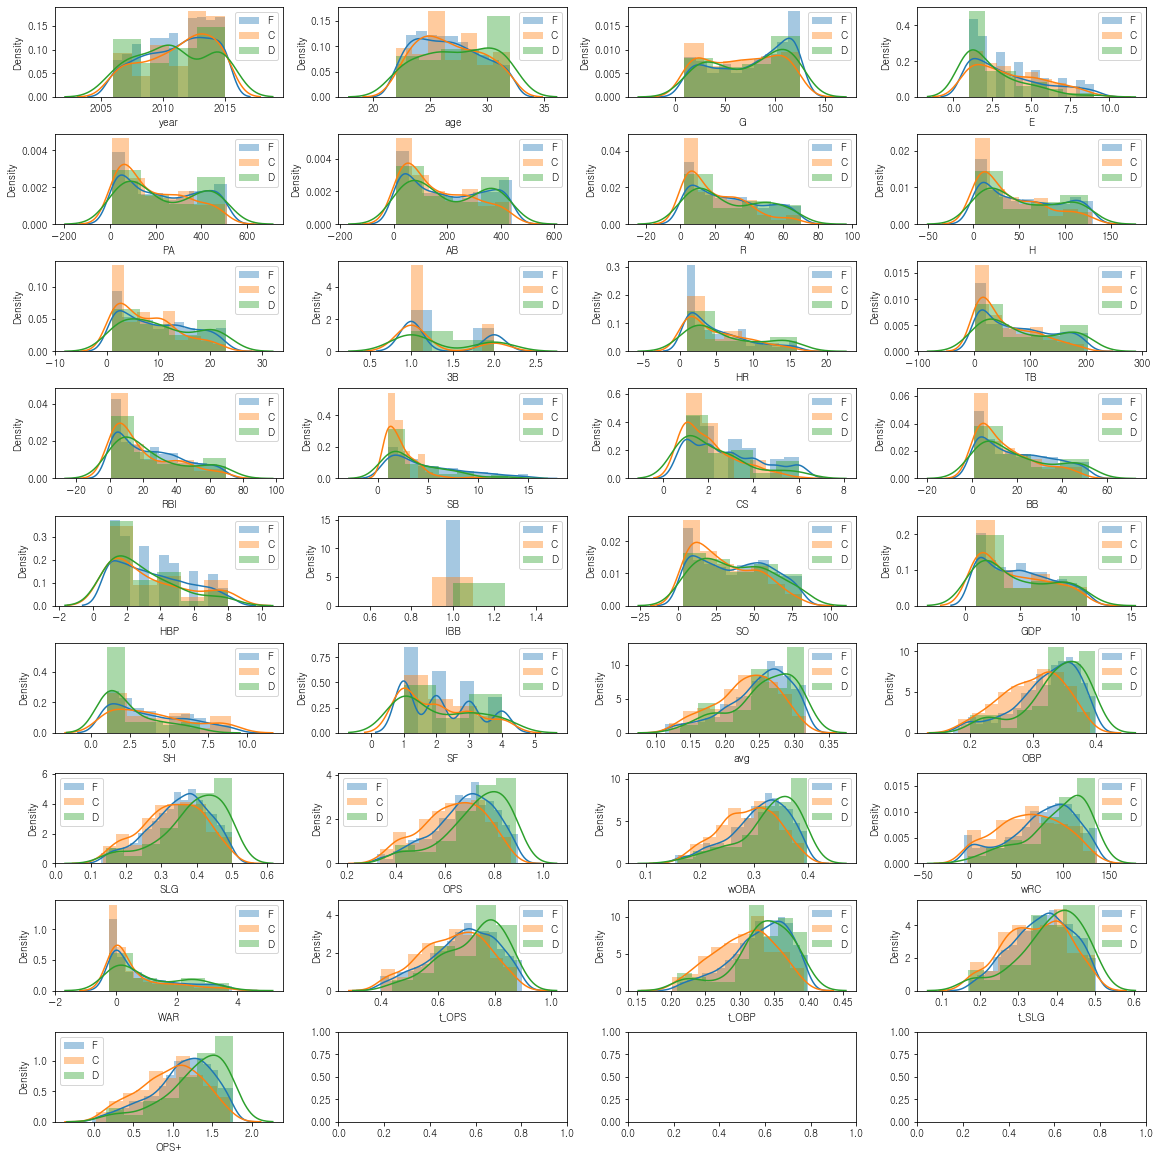

In [19]:
def postion_distplot(df, cols=4, lower=0.1, upper=0.9, yr_min=2001):
    
    df = df.loc[df['year'] >= yr_min]
    df['position2'] = df['in_out_catcher'].apply(position)
    columns = ['year', 'age', 'G', 'E', 'PA', 'AB', 'R', 'H', '2B', '3B',
               'HR', 'TB', 'RBI', 'SB', 'CS', 'BB', 'HBP', 'IBB', 'SO', 'GDP', 'SH',
               'SF', 'avg', 'OBP', 'SLG', 'OPS', 'wOBA', 'wRC', 'WAR', 't_OPS',
               't_OBP', 't_SLG', 'OPS+']

    rows = int(np.ceil(len(columns) / 4))
    cols = cols
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 4, cols * 4), constrained_layout=True)

    for i, col in enumerate(columns, 1):
        df1 = df.loc[(df[col] > df[col].quantile(lower)) &
                     (df[col] < df[col].quantile(upper))]
        pos1 = df1.loc[df1['position2'] == 'F']
        pos2 = df1.loc[df1['position2'] == 'C']
        pos3 = df1.loc[df1['position2'] == 'D']
        plt.subplot(rows, cols, i)
        sns.distplot(pos1[col], label='F')
        sns.distplot(pos2[col], label='C')
        sns.distplot(pos3[col], label='D')
        plt.legend()
    return plt.show();

def position(x):
    if x == '지명타자':
        return 'D'
    elif x[1:] == '야수':
        return 'F'
    elif x == '포수':
        return 'C'

postion_distplot(df)

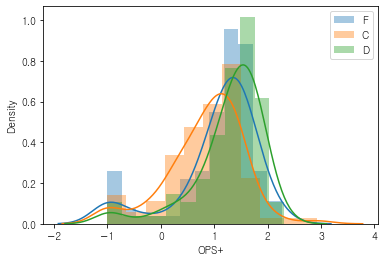

In [20]:
df['position2'] = df['in_out_catcher'].apply(position)
pos = df.copy()
pos = pos.loc[pos['year'] > 2000]
tmp1 = pos.loc[pos['position2'] == 'F'].sample(n=100)
tmp2 = pos.loc[pos['position2'] == 'C'].sample(n=100)
tmp3 = pos.loc[pos['position2'] == 'D'].sample(n=100)

tmp = pd.concat([tmp1, tmp2, tmp3], axis=0)
# tmp = tmp.groupby('position2').mean().reset_index()

sns.distplot(tmp1['OPS+'], label='F')
sns.distplot(tmp2['OPS+'], label='C')
sns.distplot(tmp3['OPS+'], label='D')
plt.legend()
plt.show();

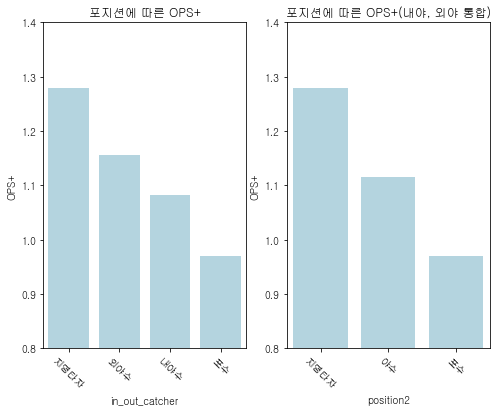

In [21]:
## 대략적인 이상치 제거
pos = df.copy()
pos = pos.loc[(pos['OPS+'] > pos['OPS+'].quantile(0.1)) & 
              (pos['OPS+'] < pos['OPS+'].quantile(0.9))]
pos_total = pos.groupby('in_out_catcher').mean().reset_index().sort_values('OPS+', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=pos_total.in_out_catcher, y=pos_total['OPS+'], color='lightblue')
plt.ylim(0.8, 1.4)
plt.title('포지션에 따른 OPS+')
plt.xticks(rotation=-45)

pos_total = pos.groupby('position2').mean().reset_index().sort_values('OPS+', ascending=False)
plt.subplot(1, 2, 2)
sns.barplot(x=pos_total.position2, y=pos_total['OPS+'], color='lightblue')
plt.ylim(0.8, 1.4)
plt.title('포지션에 따른 OPS+(내야, 외야 통합)')
plt.xticks(ticks=[0, 1, 2], labels=['지명타자', '야수', '포수'], rotation=-45)
plt.show();

## 팀별 기록

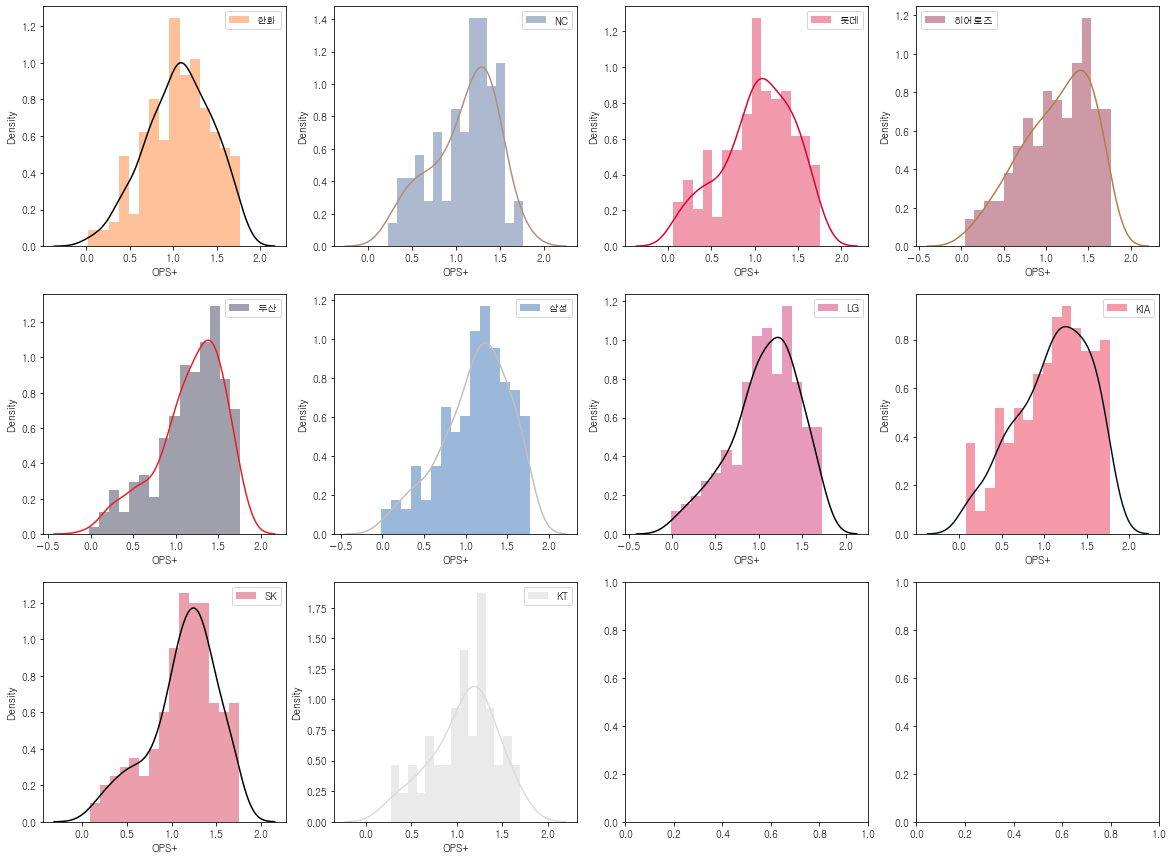

In [22]:
def distplot_by_team(df, column, lower=0.1, upper=0.9):
    team_colormap1 = {'LG':'C30452', '한화':'FF6600', 'NC':'315288', '삼성':'074CA1', '현대':'007f55', 
                     'KT':'cccccc', '롯데':'DC0232', '우리':'820024','넥센':'820024', '히어로즈':'820024', 
                     '두산':'131230', 'OB':'131230', 'SK':'CE0E2D', 'KIA':'EA0029'}
    team_colormap2 = {'LG':'000000', '한화':'000000', 'NC':'AF917B', '삼성':'C0C0C0', '현대':'000f24', 
                     'KT':'dcdcdc', '롯데':'DC0232', '우리':'B07F4A','넥센':'B07F4A', '히어로즈':'B07F4A', 
                     '두산':'ED1C24', 'OB':'ED1C24', 'SK':'000000', 'KIA':'06141F'}
    
    df = df.loc[(df[col] > df[col].quantile(lower)) &
                (df[col] < df[col].quantile(upper))]
    teams = df['team'].unique()
    
    fig, ax = plt.subplots(3, 4, figsize=(20, 15))
    for i, x in enumerate(teams, 1):
        plt.subplot(3, 4, i)
        sns.distplot(df.loc[df['team'] == x][column], bins=15, label=x,
                     kde_kws={'color':'#' + team_colormap2[x]},
                     hist_kws={'color':'#' + team_colormap1[x]})
        plt.legend()
        # plt.ylim(0, 1.5)
    return plt.show();

train.loc[train['team'].isin(['우리', '넥센', '키움']), 'team'] = '히어로즈'
# team = train.loc[(train['year'] > 2001) & 
#                  (train['OPS+'] < 1.5) &
#                  (train['OPS+'] > 0)]
# team = train.loc[train['year'] > 2001]
distplot_by_team(train, 'OPS+')

### 팀별 평균 OPS+

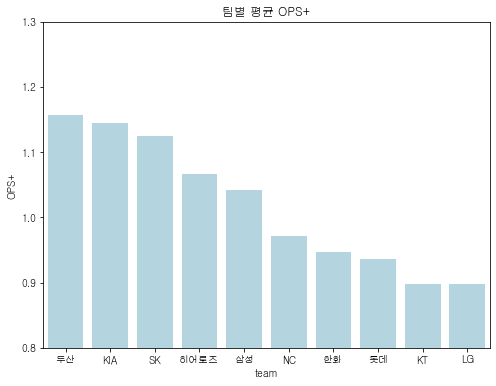

In [37]:
team = df.copy()    
team_mean = team.groupby('team').mean().reset_index().sort_values('OPS+', ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=team_mean['team'], y=team_mean['OPS+'], color='lightblue')
plt.ylim(0.8, 1.3)
plt.title('팀별 평균 OPS+')
plt.show();

### 시즌별 전체 장타 수

In [24]:
def total_XBH_plot_by_year(df, team, column='XBH', filename='kbo_xbh_plot'):
    team_colormap = {'LG':['#C30452', '#000000'], '한화':['#FF6600', '#000000'], 
                     'NC':['#315288', '#AF917B'], '삼성':['#074CA1', '#C0C0C0'], 
                     '현대':['#007f55','#000f24'], 'KT':['#cccccc', '#dcdcdc'], 
                     '롯데':['#DC0232', '#002955'], '우리':['#820024', '#B07F4A'],
                     '넥센':['#820024', '#B07F4A'], '히어로즈':['#820024', '#B07F4A'], 
                     '두산':['#131230', '#ED1C24'], 'SK':['#CE0E2D', '#000000'], 'KIA':['#EA0029', '#06141F']}
    
    df = df.loc[df['year'] >= 2001]
    df = df.groupby(['team', 'year']).sum().reset_index() # 데이터 가공
    
    if team == 'ALL':
        teams = df['team'].unique()
    elif isinstance(team, str): # input team이 단일 str이면 list로 변환
        teams = [team]
    else:                    # input team이 list면 그대로 사용
        teams = team
        
    if column == 'XBH':
        df['XBH'] = df['HR'] + df['2B'] + df['3B']
    
    fig = go.Figure()
    for tm in teams:
        #  팀 데이터 쿼리
        data = df.loc[df['team'] == tm].sort_values('year', ascending=True).reset_index(drop=True)
        
        # 팀 기록 그리기
        fig.add_trace(go.Scatter(
                          x=data['year'], y=data[column],
                          mode='markers + lines',
                          name=tm,
                          text=data['team'],
                          marker=dict(color=team_colormap[tm][0],
                                      line=dict(width=3, 
                                                color=team_colormap[tm][1]),
                                      size=12),
                          line=dict(color=team_colormap[tm][0])
                     ))
        
    # 레이아웃 설정
    fig.update_layout(title=f'시즌별 팀 {column} 기록',
                      # autosize=True,
                      template='ggplot2',
                      xaxis_title='year',
                      yaxis_title=column,
                      yaxis_range=[min(df[column]) - 0.02, max(df[column]) + 0.02])
    fig.show()
    #return plot(fig, filename=filename, auto_open=True)

In [25]:
total_XBH_plot_by_year(train, team='ALL')

### 시즌별 전체 출루 수

In [26]:
def total_BOB_plot_by_year(df, team, column='BOB', filename='kbo_bob_plot'):
    team_colormap = {'LG':['#C30452', '#000000'], '한화':['#FF6600', '#000000'], 
                     'NC':['#315288', '#AF917B'], '삼성':['#074CA1', '#C0C0C0'], 
                     '현대':['#007f55','#000f24'], 'KT':['#cccccc', '#dcdcdc'], 
                     '롯데':['#DC0232', '#002955'], '우리':['#820024', '#B07F4A'],
                     '넥센':['#820024', '#B07F4A'], '히어로즈':['#820024', '#B07F4A'], 
                     '두산':['#131230', '#ED1C24'], 'SK':['#CE0E2D', '#000000'], 'KIA':['#EA0029', '#06141F']}
    
    df = df.loc[df['year'] >= 2001]
    df = df.groupby(['team', 'year']).sum().reset_index() # 데이터 가공
    
    if team == 'ALL':
        teams = df['team'].unique()
    elif isinstance(team, str): # input team이 단일 str이면 list로 변환
        teams = [team]
    else:                    # input team이 list면 그대로 사용
        teams = team
        
    if column == 'BOB':
        df['BOB'] = df['H'] + df['BB'] + df['HBP']
    
    fig = go.Figure()
    for tm in teams:
        #  팀 데이터 쿼리
        data = df.loc[df['team'] == tm].sort_values('year', ascending=True).reset_index(drop=True)
        
        # 팀 기록 그리기
        fig.add_trace(go.Scatter(
                          x=data['year'], y=data[column],
                          mode='markers + lines',
                          name=tm,
                          text=data['team'],
                          marker=dict(color=team_colormap[tm][0],
                                      line=dict(width=3, 
                                                color=team_colormap[tm][1]),
                                      size=12),
                          line=dict(color=team_colormap[tm][0])
                     ))
        
    # 레이아웃 설정
    fig.update_layout(title=f'시즌별 팀 {column} 기록',
                      # autosize=True,
                      template='ggplot2',
                      xaxis_title='year',
                      yaxis_title=column,
                      yaxis_range=[min(df[column]) - 0.02, max(df[column]) + 0.02])
    fig.show()
    # return plot(fig, filename=filename, auto_open=True)

In [27]:
total_BOB_plot_by_year(train, team='ALL')

### 시즌별 개인 성적

In [28]:
def player_performance_by_year(df, batter_names='ALL', column='OPS+', filename='kbo_player_performence'):
    # 팀별 colormap
    team_colormap = {'LG':['#C30452', '#000000'], '한화':['#FF6600', '#000000'], 
                     'NC':['#315288', '#AF917B'], '삼성':['#074CA1', '#C0C0C0'], 
                     '현대':['#007f55','#000f24'], 'KT':['#cccccc', '#dcdcdc'], 
                     '롯데':['#DC0232', '#002955'], '우리':['#820024', '#B07F4A'],
                     '넥센':['#820024', '#B07F4A'], '히어로즈':['#820024', '#B07F4A'], 
                     '두산':['#131230', '#ED1C24'], 'SK':['#CE0E2D', '#000000'], 'KIA':['#EA0029', '#06141F']}
    
    df = df.loc[df['year'] >= 2001]
    if batter_names == 'ALL':
        df['id'] = df['batter_id'].astype('str').str.zfill(3) + ' ' + df['batter_name']
        batter_names = df.groupby('id').count().index
    elif isinstance(batter_names, str):
        batter_names = [batter_names]
    
    # plotting
    fig = go.Figure()
    for name in batter_names:
        
        # 선수 데이터 쿼리
        data = df.loc[
           (df['batter_name'] == name) |
           (df['id'] == name)
        ].sort_values(['batter_id', 'year'], ascending=True).reset_index(drop=True)
        
        # 선수 기록 그림
        fig.add_trace(go.Scatter(x=data['year'], y=data[column],
                                mode='lines + markers',
                                name=name,
                                text=data['team'],
                                marker=dict(color=[team_colormap[team][0] for team in data['team']],
                                            line=dict(width=3, 
                                                      color=[team_colormap[team][1] for team in data['team']]),
                                            size=12),
                                line=dict(color=team_colormap[data['team'][0]][0])))
        
    # 레이아웃 설정
    fig.update_layout(title=f'시즌별 선수 {column} 기록',
                      # autosize=True,
                      template='ggplot2',
                      xaxis_title='year',
                      yaxis_title=column,
                      yaxis_range=[min(df[column]) - 0.02, max(df[column]) + 0.02])
    fig.show()
    # return plot(fig, filename = filename, auto_open=True)
    

In [29]:
player_performance_by_year(train, batter_names='ALL')

### 시즌별 평균 기록

In [30]:
df['BOB'] = df['H'] + df['BB'] + df['HBP'] # 총 출루 수
df['XBH'] = df['HR'] + df['2B'] + df['3B'] # 총 장타 수
y_columns = ['year', 'avg', 'BOB', 'XBH', 'SLG', 'OBP','OPS']
year = df[y_columns]
year = year.loc[year['year'] > 2001]
year_mean = year.groupby('year').mean().reset_index()
# year_median = year.groupby('year').median().reset_index()
# year_std = year.groupby('year').std().reset_index()

mean_total = pd.DataFrame(df.mean()).T
# std_total = pd.DataFrame(df.std()).T
# median_total = pd.DataFrame(df.median()).T

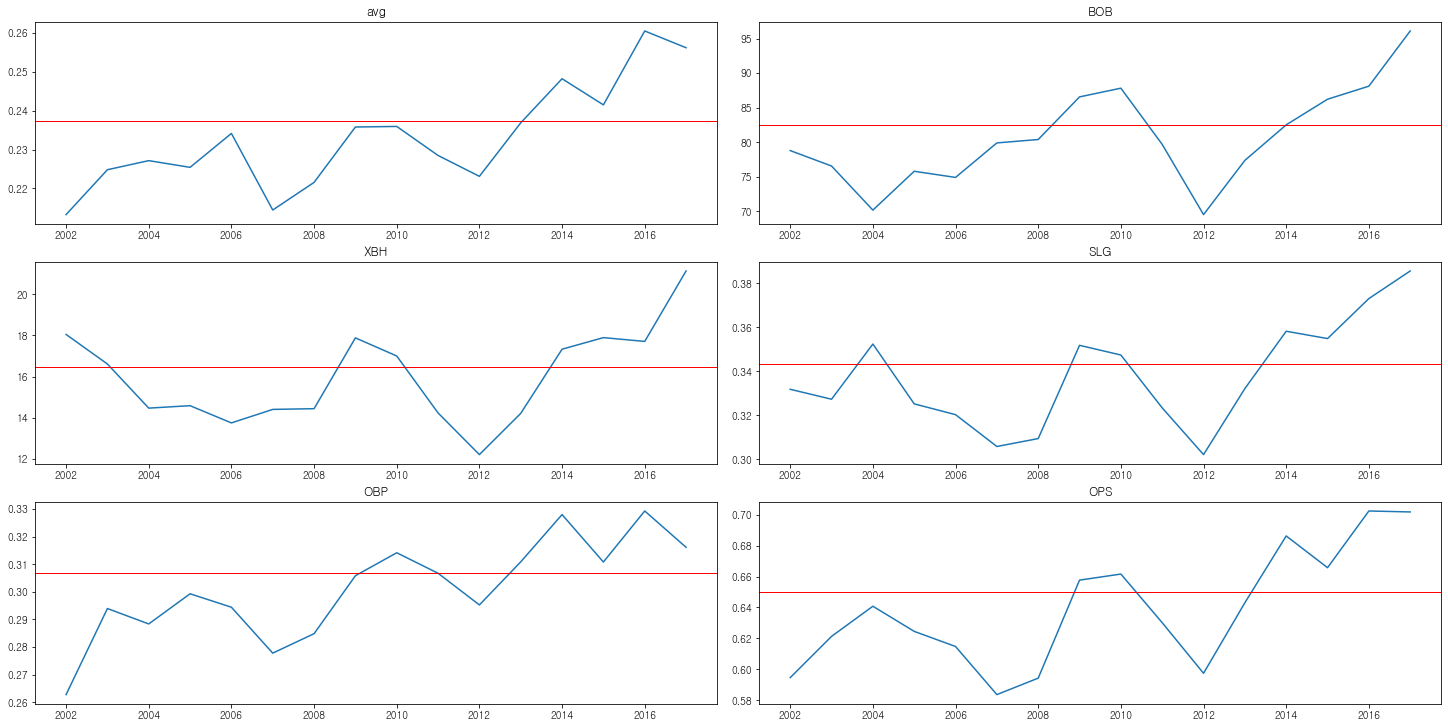

In [31]:
fig, ax = plt.subplots(3, 2, figsize=(20, 10), constrained_layout=True)

for i, col in enumerate(y_columns[1:], 1):
    plt.subplot(3, 2, i)
    plt.plot(year_mean['year'], year_mean[col])
    plt.axhline(y=mean_total[col].values, xmin=0, xmax= 2020, color='r', linewidth=1)
    # plt.axhline(y=mean_total[col].values + std_total[col].values, xmin=0, xmax= 2020, color='b', linewidth=1, linestyle='--')
    # plt.axhline(y=mean_total[col].values - std_total[col].values, xmin=0, xmax= 2020, color='b', linewidth=1, linestyle='--')
    plt.xticks(x=[i for i in range(len(year['year'].unique()))], label=list(year_mean['year'].unique()))
    plt.title(col)
plt.show();

  시즌별로 투수가 강하거나 타자가 강한 시즌이 위 그래프를 통해 나타남. 따라서 이를 반영할 수 있는 Feature Engineering이 필요하다.

### 노화에 따른 성적 변화(Aging curve)

In [72]:
from scipy import optimize

def aging_curve(func, df, target='WAR', lower=0.1, upper=0.9, 
                median=False, ma=False, window=3, opt_return=False,
                age_upper=99, data=True, curve_fit=True):
    
    df = df.loc[(df[target] > df[target].quantile(lower)) &
                (df[target] < df[target].quantile(upper)) &
                (df['age'] < age_upper)]
    if median:
        df_age = df.groupby('age').median().reset_index()
    else:
        df_age = df.groupby('age').mean().reset_index()
    
    if ma:
        title = 'Aging Curve MA(' + target + ')'
        xdata = df_age['age'].rolling(window=window).mean().dropna()
        ydata = df_age[target].rolling(window=window).mean().dropna()
    else:
        title = 'Aging Curve (' + target + ')' 
        xdata = df_age['age']
        ydata = df_age[target]
        
    popt, pcov = optimize.curve_fit(func, xdata, ydata)
    
    if opt_return:
        y_hat = func(xdata, *popt)
        return xdata, y_hat
    
    plt.figure(figsize=(10, 6))
    if data:
        plt.plot(xdata, ydata, '-o', label='avg. '+ target, color='tab:blue')
    if curve_fit:
        plt.plot(xdata, func(xdata, *popt), '-o', label=title, color='tab:orange')
    plt.xticks(ticks=xdata)
    plt.legend()
    plt.xlabel('Age')
    plt.ylabel(target)
    plt.title(title)
    return plt.show();

def func(x, a, b, c, d, e):
    return a * x ** 5 + b * x ** 4 + c * x ** 3 + d * x + e

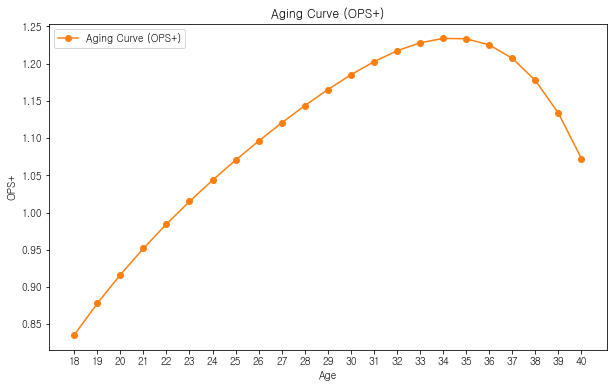

In [73]:
aging_curve(func, df, target='OPS+', age_upper=41, data=False)

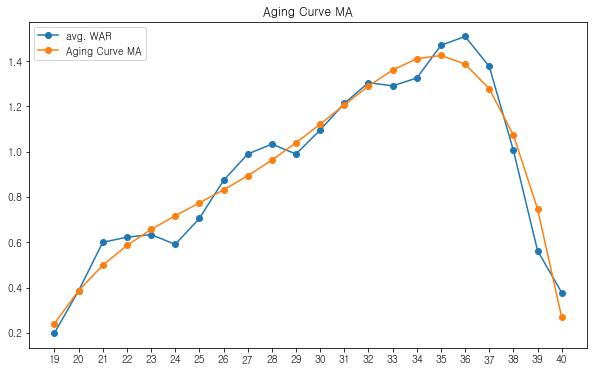

In [34]:
aging_curve(func, df, ma=True, age_upper=42, )

In [106]:
def func1(x, a, b, c):
    return a * x ** 3 + b * x ** 2 + c

age = 20
target = 'wRC'

df1 = df.loc[df['year'] >= 2001]
df_f = df1.loc[(df1['position2'] == 'F') & (df1['age'] >= age)]
df_c = df1.loc[(df1['position2'] == 'C') & (df1['age'] >= age)]
df_d = df1.loc[(df1['position2'] == 'D') & (df1['age'] >= age)]

x_f, y_f = aging_curve(func1, df_f, target=target, opt_return=True)
x_c, y_c = aging_curve(func1, df_c, target=target, opt_return=True)
x_d, y_d = aging_curve(func1, df_d, target=target, opt_return=True)

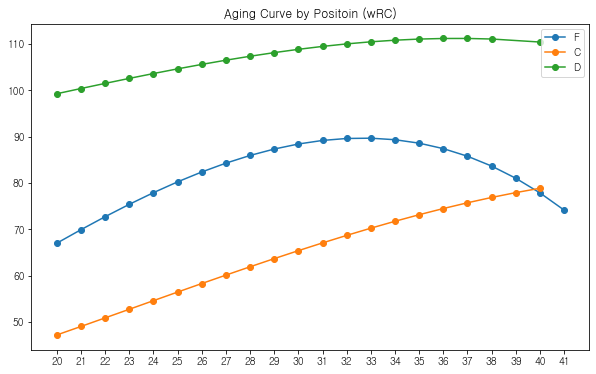

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(x_f, y_f, '-o', label='F')
plt.plot(x_c, y_c, '-o', label='C')
plt.plot(x_d, y_d, '-o', label='D')
plt.xticks(ticks=x_f)
plt.title('Aging Curve by Positoin ('+ target + ')')
plt.legend()
plt.show();

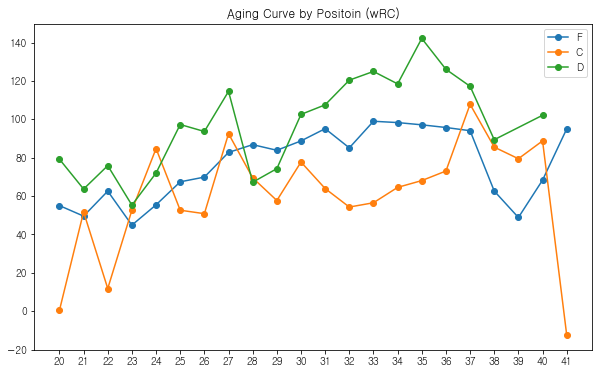

In [108]:
df_f_mean = df_f.groupby('age').mean().reset_index()
df_c_mean = df_c.groupby('age').mean().reset_index()
df_d_mean = df_d.groupby('age').mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_f_mean['age'], df_f_mean[target], '-o', label='F')
plt.plot(df_c_mean['age'], df_c_mean[target], '-o', label='C')
plt.plot(df_d_mean['age'], df_d_mean[target], '-o', label='D')
plt.xticks(ticks=x_f)
plt.title('Aging Curve by Positoin (' + target + ')')
plt.legend()
plt.show();